1. Loading Data
2. Preprocessing
 - Deal with Zero Vales
 - Deal with Missing Values
 - Deal with Unknown/Abnormal Values
 - EDA + Dimension Reduction
 - Deal with Time Stamp column
 - Deal with Turbine ID column
 - PCA
3. Model
4. Evaluation

# Loading Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

# Load the data
df = pd.read_csv('/content/drive/MyDrive/5002 Project/data/wtbdata_245days.csv')

In [ ]:
# Load spatial information dataset
df2 = pd.read_csv('/content/drive/MyDrive/5002 Project/data/sdwpf_baidukddcup2022_turb_location.CSV', index_col = 0)

In [ ]:
# Merge dfs
df = pd.merge(df, df2, on="TurbID")

# Preprocessing

## Zero Values

Some preprocessing based on the guidelines in the original paper

In [ ]:
# Zero values
# Simply treat all the values which are smaller than 0 as 0, i.e. if 𝑃𝑎𝑡𝑣 < 0, then 𝑃𝑎𝑡𝑣 = 0
df['Prtv'] = df['Prtv'].apply(lambda x: 0 if x < 0 else x)
df['Patv'] = df['Patv'].apply(lambda x: 0 if x < 0 else x)

## Dealing with Missing / Unknown / Abnormal Values

### Missing Values

We have two options to deal with Missing Values:
1. Fill these values with the neighboring turbine.
2. Fill these values with linear interpolation.

We create a column to indicate when a particular row contains missing values.

In [ ]:
# Create columns to indicate - Missing values
df['Missing'] = 0
df.loc[(df.isnull().any(axis=1)), ['Missing']] = (1)

In [ ]:
# Number of null values
df.isna().sum()

TurbID         0
Day            0
Tmstamp        0
Wspd       49518
Wdir       49518
Etmp       49518
Itmp       49518
Ndir       49518
Pab1       49518
Pab2       49518
Pab3       49518
Prtv       49518
Patv       49518
x              0
y              0
Missing        0
dtype: int64

In [ ]:
# Select only the rows containing missing values to investigate further
missing_rows = df[df['Missing'] == 1]

missing_rows["Tmstamp"].unique()

array(['00:00', '15:40', '15:00', '20:10', '21:00', '23:20', '23:30',
       '23:40', '23:50', '00:10', '00:20', '00:30', '00:40', '00:50',
       '01:00', '01:10', '01:20', '01:30', '01:40', '01:50', '02:00',
       '02:10', '02:20', '02:30', '02:40', '02:50', '03:00', '03:10',
       '03:20', '03:30', '03:40', '03:50', '04:00', '04:10', '04:20',
       '04:30', '04:40', '04:50', '05:00', '05:10', '05:20', '05:30',
       '05:40', '05:50', '06:00', '06:10', '06:20', '06:30', '06:40',
       '06:50', '07:00', '07:10', '07:20', '07:30', '07:40', '07:50',
       '08:00', '08:10', '08:20', '08:30', '08:40', '08:50', '09:00',
       '09:10', '09:20', '09:30', '09:40', '09:50', '10:00', '10:10',
       '10:20', '10:30', '10:40', '10:50', '11:00', '11:10', '11:20',
       '11:30', '11:40', '11:50', '12:00', '12:10', '12:20', '12:30',
       '12:40', '12:50', '13:00', '13:10', '13:20', '13:30', '13:40',
       '13:50', '14:00', '14:10', '14:20', '14:30', '14:40', '14:50',
       '15:10', '15:

Looks like there are missing values for almost every time stamp, lets see whether it could be only one turbine that is faulty and thats why has these missing values.

In [ ]:
# Check for a random timestamp if there are only missing values for a single turbine or multiple
missing_rows[missing_rows["Tmstamp"]=="15:10"]

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,x,y,Missing
9451,1,66,15:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3349.8515,5939.23193,1
18091,1,126,15:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3349.8515,5939.23193,1
28891,1,201,15:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3349.8515,5939.23193,1
44731,2,66,15:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3351.0017,6416.64673,1
44875,2,67,15:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3351.0017,6416.64673,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595995,131,67,15:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.3458,5284.65439,1
4631131,132,66,15:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,62.6774,5749.90633,1
4666411,133,66,15:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.4309,6231.32903,1
4701691,134,66,15:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.3385,6713.46517,1


No. It looks like there are multiple turbines that have missing values at a given time stamp. We cannot drop the NA values because it will break the time-series sequence. It would also not make sense to set them to 0. Therefore, let's attempt to fill in the missing values with the nearest Turbine's value for any given time stamp.

#### Nearest Neighbour to fill Missing values

In [ ]:
nn_df = df[['TurbID', 'x', 'y']].drop_duplicates().set_index('TurbID')
# Calculate the distances to find closest neighbour
from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(nn_df[['x', 'y']].values)
closest_neighbor = dist_matrix.argsort(axis=1)[:, 1]
# Create a new df with the closest neighbour 
df_neighbor = pd.DataFrame({'TurbID': nn_df.index, 'ClosestNeighbor': nn_df.index[closest_neighbor]})
df_neighbor 

,TurbID,ClosestNeighbor
0,1,24
1,2,3
2,3,4
3,4,5
4,5,4
...,...,...
129,130,131
130,131,132
131,132,131
132,133,132


In [ ]:
df = pd.merge(df, df_neighbor, on='TurbID', how = "left")
df

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,x,y,Missing,ClosestNeighbor
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3349.8515,5939.23193,1,24
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,0.0,494.66,3349.8515,5939.23193,0,24
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,0.0,509.76,3349.8515,5939.23193,0,24
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,0.0,542.53,3349.8515,5939.23193,0,24
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,0.0,509.36,3349.8515,5939.23193,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727515,134,245,23:10,7.79,2.80,-0.07,3.95,216.51,6.03,6.03,6.03,0.0,601.44,11.3385,6713.46517,0,113
4727516,134,245,23:20,8.06,4.39,0.23,3.94,216.51,5.81,5.81,5.81,0.0,673.79,11.3385,6713.46517,0,113
4727517,134,245,23:30,8.08,2.28,-0.16,4.15,216.51,0.68,0.68,0.68,0.0,999.36,11.3385,6713.46517,0,113
4727518,134,245,23:40,8.46,0.80,-0.14,4.32,216.51,0.02,0.02,0.02,0.0,1100.89,11.3385,6713.46517,0,113


In [ ]:
# # Function to replace missing values with values from the closest neighbor
# def replace_missing_with_closest_neighbor(row, df):
#     if row['Missing'] == 1:
#         closest_neighbor_id = row['ClosestNeighbor']
#         closest_neighbor = df.loc[(df['TurbID'] == closest_neighbor_id) & (df['Day'] == row['Day']) & (df['Tmstamp'] == row['Tmstamp'])]
        
#         if not closest_neighbor.empty:
#             for column in row.index:
#                 if column not in ['TurbID', 'Day', 'Tmstamp', 'x', 'y', 'Abnormal', 'Missing', 'ClosestNeighbor']:
#                     row[column] = closest_neighbor.iloc[0][column]

#     return row

# df = df.apply(lambda row: replace_missing_with_closest_neighbor(row, df), axis=1)

In [ ]:
df = df.drop('ClosestNeighbor', axis=1)

We do not perform filling the missing values using the closest turbine's value at that given day and time because it takes a lot of time and computational resources to run on the entire dataframe. However, when testing on smaller sample dataset, the method of Linear Interpolation yields better performance during prediction.
Next section is the code for using linear interporlation to fill missing values. 

We still keep the code for closest neighbour here for reference, methodology and usability of code in the case someone would like to experiment further.

#### Linear Interpolation for dealing with Missing values

In [ ]:
count_missing = df['Missing'].sum()
print(f"Number of missing values: {count_missing}")

Number of missing values: 49518


We first deal with missing values before dealing with abnormal values because after performing interpolation, the missing values may then become 'abnormal' or 'unknown'.

In [ ]:
# Columns to interpolate
cols_to_interpolate = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']

In [ ]:
def interpolate_missing(group):
    missing_rows_index = group[group['Missing'] == 1].index
    group.loc[missing_rows_index, cols_to_interpolate] = group[cols_to_interpolate].interpolate(method='linear', axis=0, limit_direction='both').loc[missing_rows_index]
    return group

df = df.groupby(['TurbID', 'Day'], group_keys=False).apply(interpolate_missing)

# # Fill remaining missing values with values from the nearest turbine
# for col in cols_to_interpolate:
#     df[col] = df.groupby(['Day', 'Tmstamp', 'ClosestNeighbor'])[col].transform(lambda x: x.fillna(x.mean()))

# Fill remaining missing values with forward and backward fill
df[cols_to_interpolate] = df[cols_to_interpolate].fillna(method='bfill').fillna(method='ffill')

In [ ]:
# Number of null values
df.isna().sum()

TurbID     0
Day        0
Tmstamp    0
Wspd       0
Wdir       0
Etmp       0
Itmp       0
Ndir       0
Pab1       0
Pab2       0
Pab3       0
Prtv       0
Patv       0
x          0
y          0
Missing    0
dtype: int64

In [ ]:
# Save the cleaned DataFrame to a CSV file
# df.to_csv('/content/drive/MyDrive/5002 Project/data/cleaned_data.csv', index=False)

# df = pd.read_csv('/content/drive/MyDrive/5002 Project/data/cleaned_data.csv')

In [ ]:
df = df.drop('Missing', axis=1)

### Abnormal values

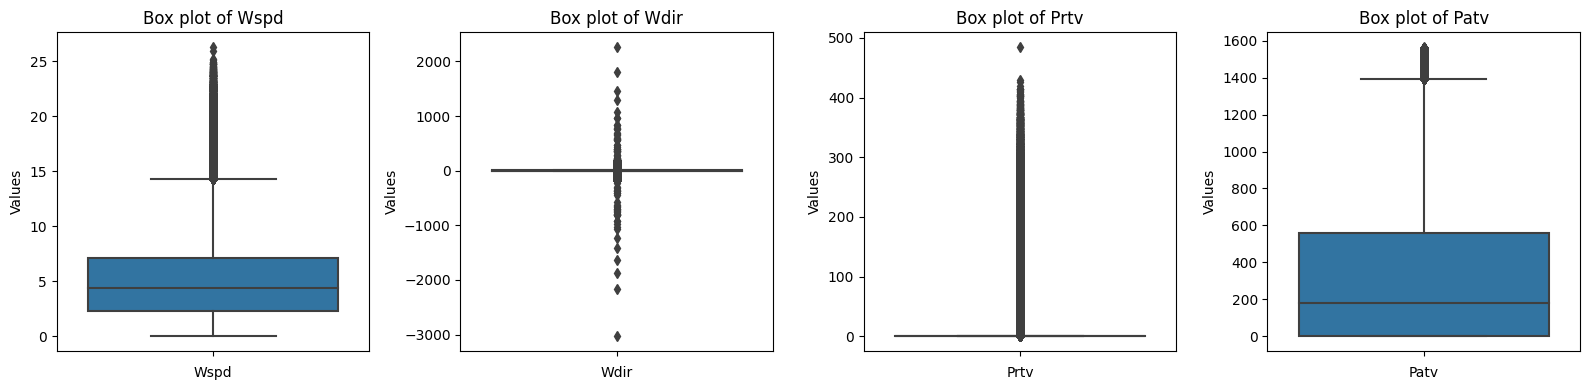

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named "df" and the columns you want to plot are named "col1" and "col2":
cols_to_plot = ["Wspd", "Wdir", "Prtv", "Patv"]
num_cols = len(cols_to_plot)
fig, axs = plt.subplots(nrows=1, ncols=num_cols, figsize=(4*num_cols, 4))

for i, col in enumerate(cols_to_plot):
    # Create a box plot for the current column
    sns.boxplot(y=df[col], ax=axs[i])
    
    # Add a title and labels for the x and y axes
    axs[i].set_title(f'Box plot of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

The plot above investigates a few features to understand the state of outliers before dealing with abnormal values.

After dealing with the missing values, we then create a new column to indicate abnormal values. Note: We treat 'Abnormal' and 'Unknown' values as the same, thereby creating only one column to indicate both.

In [ ]:
df['Abnormal'] = 0
df.loc[(df['Patv'] <= 0) & (df['Wspd'] > 2.5) | 
       (df['Pab1'] > 89) | (df['Pab2'] > 89) | (df['Pab3'] > 89) | 
       (df['Ndir'] > 720) | (df['Ndir'] < -720) | 
       (df['Wdir'] > 180) | (df['Wdir'] < -180), ['Abnormal']] = (1)
count_abnormal = df['Abnormal'].sum()
print(f"Number of abnormal values: {count_abnormal}")

Number of abnormal values: 1087276


In [ ]:
# Store the indices of the original abnormal rows
original_abnormal_indices = df.loc[df['Abnormal'] == 1].index

# Store the original abnormal data
original_abnormal_data = df.loc[original_abnormal_indices, cols_to_interpolate].copy()

The following is the code used to replace the abnormal values. It identifies the row containing the abnormal values and then replaces it with the average of the immediate previous and next normal rows. 

We comment it out because we already save the cleaned df into a csv and load it to save time. (code for this is down below)

In [ ]:
# # Function to handle the replacement logic
# def replace_abnormal_rows(group):
#     group = group.copy()
#     abnormal_rows = group['Abnormal'] == 1
#     normal_rows = group['Abnormal'] == 0
#     columns_to_replace = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']

#     if abnormal_rows.any():
#         for col in columns_to_replace:
#             for index, row in group[abnormal_rows].iterrows():
#                 previous_normal_index = group[normal_rows].loc[:index].index.max()
#                 next_normal_index = group[normal_rows].loc[index:].index.min()

#                 if pd.isna(previous_normal_index) and pd.notna(next_normal_index):
#                     group.loc[index, col] = group.loc[next_normal_index, col]
#                 elif pd.notna(previous_normal_index) and pd.isna(next_normal_index):
#                     group.loc[index, col] = group.loc[previous_normal_index, col]
#                 elif pd.notna(previous_normal_index) and pd.notna(next_normal_index):
#                     group.loc[index, col] = (group.loc[previous_normal_index, col] +
#                                              group.loc[next_normal_index, col]) / 2

#     return group

# result = df.groupby(['TurbID', 'Day'], group_keys=False).apply(replace_abnormal_rows)

# # Replace the original DataFrame with the result
# df = result.reset_index(drop=True)

In [ ]:
# Save the cleaned DataFrame to a CSV file
# df.to_csv('/content/drive/MyDrive/5002 Project/data/cleaned_data_2.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np

# loading the cleaned df from csv file to save time
df = pd.read_csv('/content/drive/MyDrive/5002 Project/data/cleaned_data_2.csv')

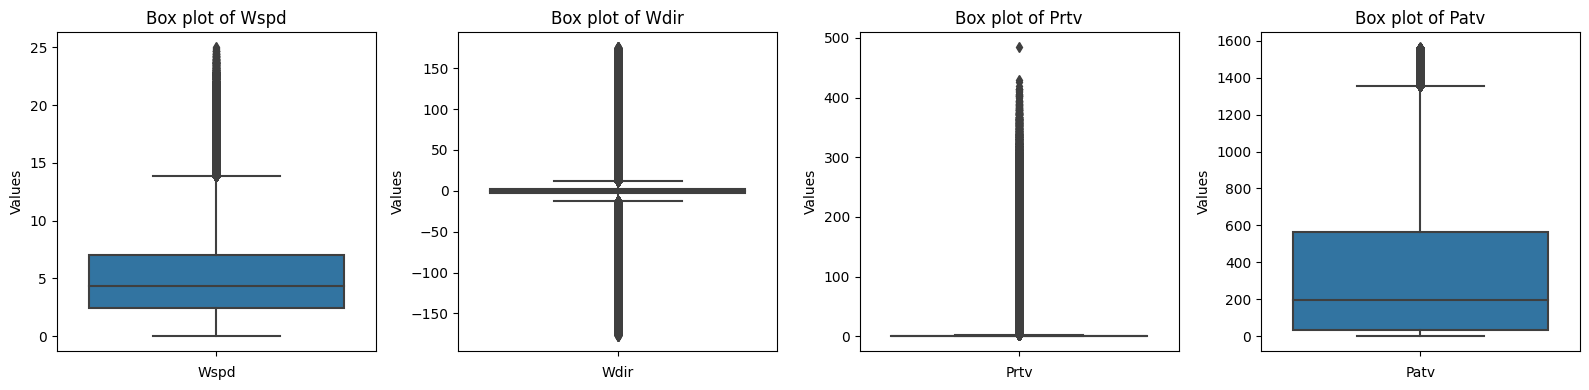

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named "df" and the columns you want to plot are named "col1" and "col2":
cols_to_plot = ["Wspd", "Wdir", "Prtv", "Patv"]
num_cols = len(cols_to_plot)
fig, axs = plt.subplots(nrows=1, ncols=num_cols, figsize=(4*num_cols, 4))

for i, col in enumerate(cols_to_plot):
    # Create a box plot for the current column
    sns.boxplot(y=df[col], ax=axs[i])
    
    # Add a title and labels for the x and y axes
    axs[i].set_title(f'Box plot of {col}')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Values')

plt.tight_layout()
plt.show()

The plot above investigates a few features to understand the state of outliers before dealing with abnormal values. We see that there are still quite a lot of outliers, however, after doing some research online about specific attributes of wind turbines and intuitively, its not feasible to remove or change them. We will still investigate and do dimension reduction which may help remove some columns with a lot of outliers.  

## Dimension Reduction

In [ ]:
df.columns

Index(['TurbID', 'Day', 'Tmstamp', 'Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir',
       'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv', 'x', 'y', 'Abnormal'],
      dtype='object')

In [ ]:
df = df.drop('Abnormal', axis=1)

<ipython-input-7-bf98228684ea>:6: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


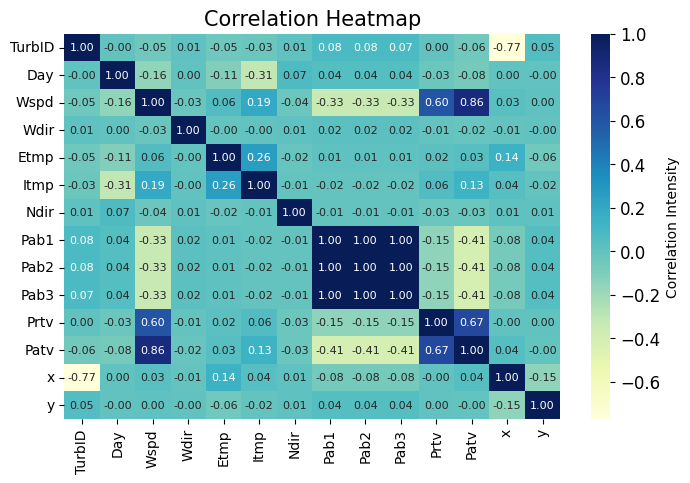

In [ ]:
# heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Create the heatmap using the correlation matrix of the dataframe
corr_matrix = df.corr()
plt.subplots(figsize=(8, 5))
plt.title('Correlation Heatmap', fontsize=15)
plt.xlabel('X Label', fontsize=10)
plt.ylabel('Y Label', fontsize=10)
sns.heatmap(corr_matrix, cmap='YlGnBu', yticklabels=corr_matrix.columns, xticklabels=corr_matrix.columns, annot=True, fmt=".2f", annot_kws={"size": 8}, cbar_kws={"label": "Correlation Intensity"})
cbar = plt.gcf().axes[-1]
cbar.tick_params(labelsize=12)

# Show the heatmap
plt.show()

Insights: 

1. Perfect correlation between Pab1, Pab2 and Pab3. Therefore we will combine them into Pab_max, which is basically the maximum value amongst Pab1, Pab2 and Pab3.
2. There is little to no correlation between the target variable (Patv) and the following features: 'Wdir', 'Etmp', 'Itmp', 'Ndir'. Therefore, we will drop them.

In [ ]:
# Combine Pab1, Pab2 and Pab3 into Pab_max
df["Pab_max"] = df[['Pab1', 'Pab2', 'Pab3']].max(axis=1)
df = df.drop(columns = ['Pab1', 'Pab2', 'Pab3'])

In [ ]:
# Drop the following features: 'Wdir', 'Etmp', 'Itmp', 'Ndir' 
df = df.drop(columns=['Wdir', 'Etmp', 'Itmp', 'Ndir'], axis=1)

## Dealing with Tmstamp:

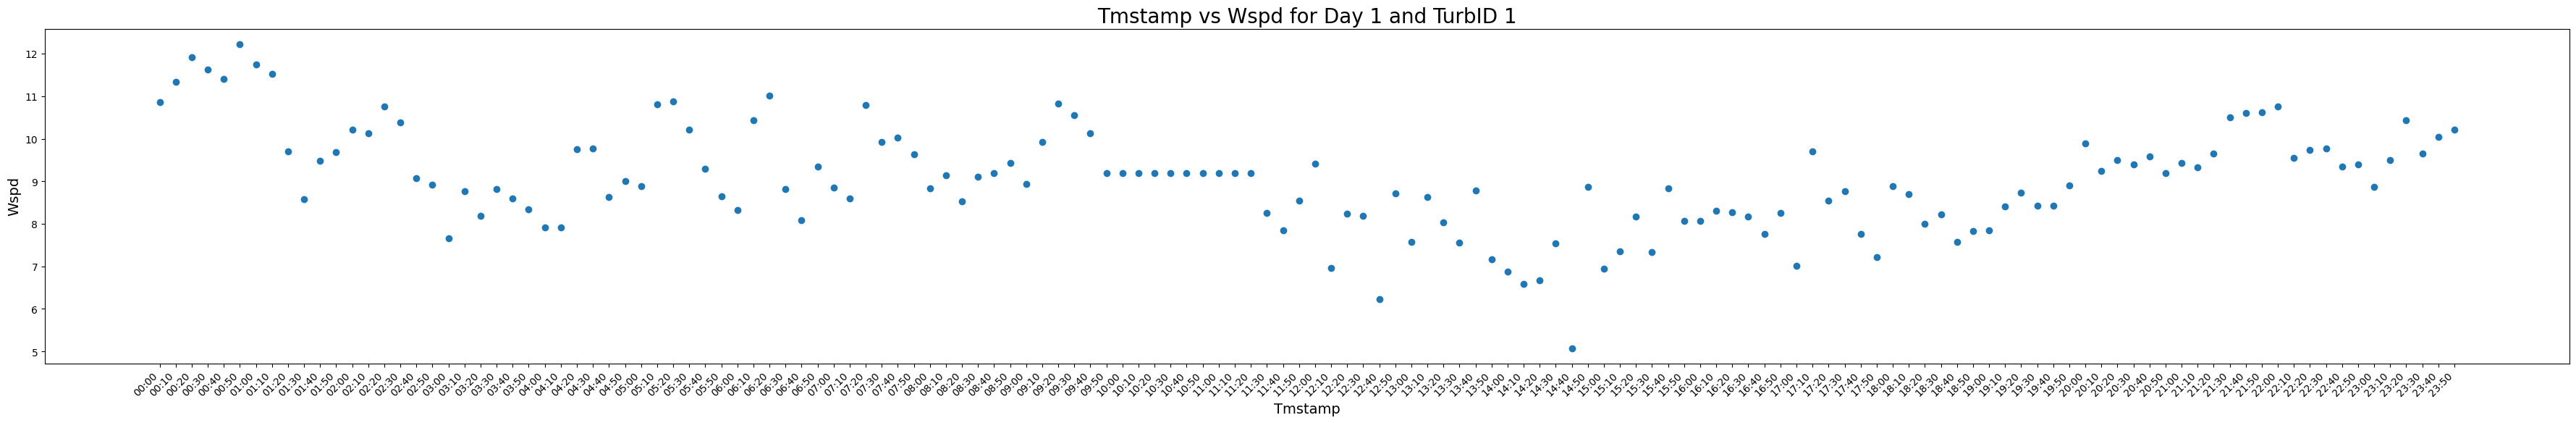

In [ ]:
import matplotlib.pyplot as plt

# Create a new dataframe with only the data for random day and turbine
df_subset = df[(df['Day'] == 10) & (df['TurbID'] == 3)]

# Select only the columns we want to plot
df_plot = df_subset[['Day', 'TurbID', 'Tmstamp', 'Wspd', 'Patv']]

# Create a scatter plot of Tmstamp vs Wspd
fig, ax = plt.subplots(figsize=(45, 6))
ax.scatter(df_plot['Tmstamp'], df_plot['Wspd'])

# Set the title and axis labels
ax.set_title('Tmstamp vs Wspd for Day 1 and TurbID 1', fontsize=20)
ax.set_xlabel('Tmstamp', fontsize=14)
ax.set_ylabel('Wspd', fontsize=14)

# Set the x-axis tick labels to display dates
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

Plot to see if there is any trend throughout the day - the insight is that for some turbines for some days we notice a trend where the Wspd increases for the first half of the day and then decreases before increasing again towards the end of the day. We use Wspd since it has a strong correlation with Patv. Moreover, intuitively, using Tmstamp as a feature may be beneficial as it may have hidden patterns. 

Therefore, we convert 'Tmstamp' into sine and cosine values since these functions are periodic, often used for time series forecasting tasks and data. Moreover, they help to capture the cyclical nature of the time feature. 

In [ ]:
df['Tmstamp'] = pd.to_datetime(df['Tmstamp'], format='%H:%M')
df['hour_sin'] = np.sin(2 * np.pi * df['Tmstamp'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['Tmstamp'].dt.hour / 24)
df['minute_sin'] = np.sin(2 * np.pi * df['Tmstamp'].dt.minute / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['Tmstamp'].dt.minute / 60)
df = df.drop("Tmstamp", axis=1)

In [ ]:
df

,TurbID,Day,Wspd,Prtv,Patv,x,y,Abnormal,Pab_max,hour_sin,hour_cos,minute_sin,minute_cos
0,1,1,6.17,0.0,494.66,3349.8515,5939.23193,0,1.00,0.000000,1.000000,0.000000e+00,1.0
1,1,1,6.17,0.0,494.66,3349.8515,5939.23193,0,1.00,0.000000,1.000000,8.660254e-01,0.5
2,1,1,6.27,0.0,509.76,3349.8515,5939.23193,0,1.00,0.000000,1.000000,8.660254e-01,-0.5
3,1,1,6.42,0.0,542.53,3349.8515,5939.23193,0,1.00,0.000000,1.000000,5.665539e-16,-1.0
4,1,1,6.25,0.0,509.36,3349.8515,5939.23193,0,1.00,0.000000,1.000000,-8.660254e-01,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4727515,134,245,7.79,0.0,601.44,11.3385,6713.46517,0,6.03,-0.258819,0.965926,8.660254e-01,0.5
4727516,134,245,8.06,0.0,673.79,11.3385,6713.46517,0,5.81,-0.258819,0.965926,8.660254e-01,-0.5
4727517,134,245,8.08,0.0,999.36,11.3385,6713.46517,0,0.68,-0.258819,0.965926,5.665539e-16,-1.0
4727518,134,245,8.46,0.0,1100.89,11.3385,6713.46517,0,0.02,-0.258819,0.965926,-8.660254e-01,-0.5


## TurbID

'TurbID' is a categorial variable with 134 unique values. To deal with this, we can resort to one-hot-encoding which would completely remove any ranking bias but that would increase our dimensions by 134 which is not feasible. Therefore, we will split 'TurbID' into 'Cluster' and 'ID'. Cluster will represent the turbine's location with respect to it's X-coordinate and ID will represent the turbine's location with respect to it's Y-cooridinate, although this will not completely remove the ranking bias, it will certainly reduce it drastically.

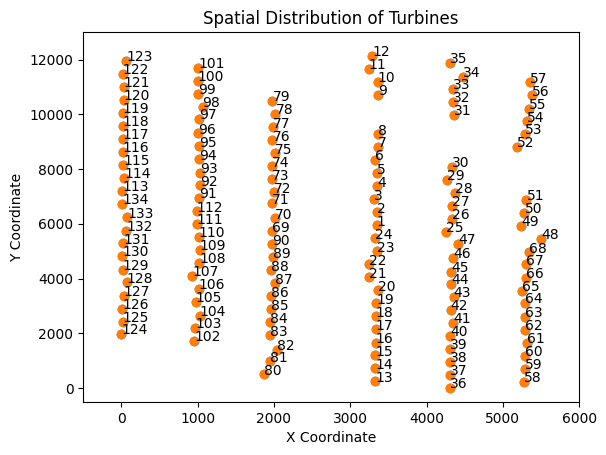

In [ ]:
# Visualizing the Turbines
viz_df = pd.read_csv('/content/drive/MyDrive/5002 Project/data/sdwpf_baidukddcup2022_turb_location.CSV')
import matplotlib.pyplot as plt

# Extract X, Y coordinates, and turbine ID from the dataset
x = viz_df['x']
y = viz_df['y']
turb_id = viz_df['TurbID']

# Create a scatter plot of the turbine locations
plt.scatter(x, y)

# Add labels for each turbine ID
for i, id in enumerate(turb_id):
    plt.text(x[i], y[i], str(id))

plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Spatial Distribution of Turbines')
plt.scatter(x, y)
plt.xlim(-500, 6000)
plt.ylim(-500, 13000)
plt.show()

In [ ]:
id = df[['TurbID', 'x', 'y']].drop_duplicates()

In [ ]:
df['TurbID'].max().sum()

134

In [ ]:
# Create a new column 'Cluster' based on the 'x' values
id['Cluster'] = pd.cut(id['x'], bins=[-500, 500, 1500, 2500, 4000, 4750, float('inf')], labels=[1, 2, 3, 4, 5, 6])

# Group the data by 'Cluster'
gb = id.groupby('Cluster')

# Create a new column 'ID' based on the 'y' values within each cluster
id['ID'] = 0  # Initialize with a sentinel value

for name, group in gb:
    # Sort the group by Y value in descending order
    group = group.sort_values('y', ascending=False)
    # Assign ID values from 1 to n in ascending order based on Y value
    ids = range(1, len(group)+1)
    print(f"Cluster {name}: {ids}")
    id.loc[group.index, 'ID'] = ids

Cluster 1: range(1, 23)
Cluster 2: range(1, 23)
Cluster 3: range(1, 23)
Cluster 4: range(1, 25)
Cluster 5: range(1, 24)
Cluster 6: range(1, 22)


In [ ]:
print(id.groupby('Cluster')['ID'].max().sum())

134


In [ ]:
id = id.drop(columns=["x", "y"], axis=1)
merged_df = pd.merge(df, id, on='TurbID', how = "left")
merged_df.columns

Index(['TurbID', 'Day', 'Wspd', 'Prtv', 'Patv', 'x', 'y', 'Abnormal',
       'Pab_max', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos',
       'Cluster', 'ID'],
      dtype='object')

We no longer need 'TurbID' since we split it into 'Cluster' and 'ID'. We also no longer need 'x' and 'y' since we used them for the splitting and the values by itself have no correlation with the target variable 'Patv'.

In [ ]:
df = merged_df.copy()
# rename
df = df.drop(columns=["x", "y", "TurbID"], axis=1)
df = df[['hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'Day', 'Cluster', 'ID', 'Wspd', 'Pab_max', 'Prtv', 'Patv']]

In [ ]:
df.columns

Index(['hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'Day', 'Cluster',
       'ID', 'Wspd', 'Pab_max', 'Prtv', 'Patv'],
      dtype='object')

## PCA

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # Separate variables that are not needed to run PCA on
# features = train_df.drop(columns=['Patv', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'Cluster', 'ID', 'Abnormal', 'Day'])

# # Standardize the feature matrix
# scaler = StandardScaler()
# X = scaler.fit_transform(features)

# # Apply PCA
# pca = PCA()
# X_pca = pca.fit_transform(X)

# # Determine the number of important components
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# n_important_components = np.argmax(cumulative_explained_variance >= 0.95) + 1

# # Print the percent importance of each feature
# print('Percent Importance of Each Feature:')
# for i, var in enumerate(pca.explained_variance_ratio_):
#     print(f'PC{i+1}: {var*100:.2f}%')

# # Keep the important components
# pca = PCA(n_components=n_important_components)
# X_pca = pca.fit_transform(X)

# # Create a DataFrame with the important components
# important_components_df = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, n_important_components + 1)])

# # Add the target variable back to the new DataFrame
# important_components_df['Patv'] = train_df['Patv']
# important_components_df['Cluster'] = train_df['Cluster']
# important_components_df['ID'] = train_df['ID']
# important_components_df['hour_sin'] = train_df['hour_sin']
# important_components_df['hour_cos'] = train_df['hour_cos']
# important_components_df['minute_sin'] = train_df['minute_sin']
# important_components_df['minute_cos'] = train_df['minute_cos']
# important_components_df['Abnormal'] = train_df['Abnormal']
# important_components_df['Day'] = train_df['Day']

# # Rename the columns of the new DataFrame to retain original feature names
# important_components_df.columns = list(features.columns[n] for n in range(n_important_components)) + ['Patv'] + ['Cluster'] + ['ID'] + ['hour_sin'] + ['hour_cos'] + ['minute_sin'] + ['minute_cos'] + ['Abnormal'] + ['Day']

In [ ]:
# features.columns

In [ ]:
# important_components_df.columns

In [ ]:
# # select the columns in the desired order
# df = important_components_df.loc[:, ['Patv', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'Cluster', 'ID', 'Abnormal', 'Day']]
# df.columns

We run PCA on a few attributes but decide not to remove any other attributes as they seem important intuitively such as Day, Time (hour and minutes), TurbID (cluster and ID)

# Model

In [ ]:
test = df.copy()

In [ ]:
data = test.copy()

In [ ]:
# df.to_csv('/content/drive/MyDrive/5002 Project/data/cleaned_data_3.csv', index=False)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv('/content/drive/MyDrive/5002 Project/data/cleaned_data_3.csv')

In [4]:
data.columns

Index(['hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'Day', 'Cluster',
       'ID', 'Wspd', 'Pab_max', 'Prtv', 'Patv'],
      dtype='object')

In [5]:
# rearrange
data = data[['hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'Cluster', 'ID', 'Day', 'Wspd', 'Pab_max', 'Prtv', 'Patv']]

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Separate features that should not be scaled
data_not_scaled = data[['Cluster', 'ID', 'Patv', 'Day', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']]

# Scale the remaining features
scaler = MinMaxScaler()
data_scaled = pd.DataFrame(scaler.fit_transform(data.drop(['Cluster', 'ID', 'Patv', 'Day', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos'], axis=1)),
                           columns=data.columns.difference(['Cluster', 'ID', 'Patv', 'Day', 'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos']))

# Combine the scaled and not-scaled data
data_processed = pd.concat([data_not_scaled, data_scaled], axis=1)

In [7]:
data.groupby(['Cluster', 'ID']).count()['Day'].value_counts()

35280    134
Name: Day, dtype: int64

In [8]:
# rearrange
data_processed = data_processed[['hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 'Cluster', 'ID', 'Day', 'Wspd', 'Pab_max', 'Prtv', 'Patv']]

In [9]:
# Before grouping
unique_turbines = data_processed[['Cluster', 'ID']].drop_duplicates()
print("Number of unique turbines before grouping:", len(unique_turbines))

# After grouping
grouped_turbines = data_processed.groupby(['Cluster', 'ID']).count().reset_index()[['Cluster', 'ID']]
print("Number of unique turbines after grouping:", len(grouped_turbines))

Number of unique turbines before grouping: 134
Number of unique turbines after grouping: 134


In [10]:
import tensorflow as tf
from tensorflow.keras.layers import GRU, Conv1D, Dense, LSTM, Dropout, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from keras.regularizers import l2

# Custom RMSE metric
def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

reg_lambda = 0.03

def create_model():
    model = Sequential([
        Dense(128, activation='relu', input_shape=(1008, 9), kernel_regularizer=l2(reg_lambda)),
        Dropout(0.7),
        Dense(64, activation='relu', kernel_regularizer=l2(reg_lambda)),
        Dropout(0.7),
        Dense(32, activation='relu', kernel_regularizer=l2(reg_lambda)),
        Dropout(0.7),
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(reg_lambda)),
        Dropout(0.7),
        Dense(288)
    ])

    lr = 0.0005
    optimizer = Adam(learning_rate=lr)

    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', root_mean_squared_error])

    return model

class TurbineDataGenerator(Sequence):
    def __init__(self, turbine_data, window_size=1008, future_steps=288, step_size=288, batch_size=24):
        self.data = turbine_data
        self.window_size = window_size
        self.future_steps = future_steps
        self.step_size = step_size
        self.batch_size = batch_size
        self.turbine_indices = []

        for i in range(0, len(turbine_data) - window_size - future_steps, step_size):
            self.turbine_indices.append((i, i + window_size))

    def __len__(self):
        return int(np.ceil(len(self.turbine_indices) / self.batch_size))

    def __getitem__(self, idx):
        batch_indices = self.turbine_indices[idx * self.batch_size: (idx + 1) * self.batch_size]

        X = []
        y = []
        for start, end in batch_indices:
            X.append(self.data.iloc[start:end, :].drop(['Cluster', 'ID'], axis=1).values)
            y.append(self.data.iloc[end:end + self.future_steps]['Patv'].values)

        return np.array(X), np.array(y)

class PrintProgress(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        train_rmse = np.sqrt(logs['loss'])
        val_rmse = np.sqrt(logs['val_loss'])
        train_mae = logs['mae']
        val_mae = logs['val_mae']
        print(f"Epoch {epoch + 1}, Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}, Train MAE: {train_mae:.4f}, Validation MAE: {val_mae:.4f}")

In [11]:
# Calculate the number of rows corresponding to 80% of 245 days
rows_per_day = 24 * 6  # 24 hours * 6 (10-minute intervals)
total_days = 245
train_days = int(total_days * 0.8)
train_rows = train_days * rows_per_day
# Select the appropriate rows for the train data
train_data = data_processed[data_processed.index % (total_days * rows_per_day) < train_rows].reset_index(drop=True)
# Verify the number of unique turbines in the train data
unique_turbines_train = train_data[['Cluster', 'ID']].drop_duplicates()
print("Number of unique turbines in train data:", len(unique_turbines_train))
# Prepare the train generator
train_generator = TurbineDataGenerator(train_data, batch_size=24)
# Select the appropriate rows for the validation data
validation_data = data_processed[data_processed.index % (total_days * rows_per_day) >= train_rows].reset_index(drop=True)
# Verify the number of unique turbines in the validation data
unique_turbines_validation = validation_data[['Cluster', 'ID']].drop_duplicates()
print("Number of unique turbines in validation data:", len(unique_turbines_validation))
# Prepare the validation generator
validation_generator = TurbineDataGenerator(validation_data, batch_size=24)

Number of unique turbines in train data: 134
Number of unique turbines in validation data: 134


In [12]:
turbine_models = {}
best_validation_rmse = []
best_validation_mae = []
best_train_rmse = []
best_train_mae = []
turbine_histories = []

for cluster_id, turbine_data in train_data.groupby(['Cluster', 'ID']):
    print(f"Training model for turbine {cluster_id}")
    
    # Create the generators for the current turbine
    turbine_train_generator = TurbineDataGenerator(turbine_data)
    turbine_validation_data = validation_data[(validation_data['Cluster'] == cluster_id[0]) & (validation_data['ID'] == cluster_id[1])]
    turbine_validation_generator = TurbineDataGenerator(turbine_validation_data)
    
    # Create the model for the current turbine
    turbine_model = create_model()
    
    # Set up the callbacks for the current turbine
    # checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/5002 Project/model/Conv/turbine_{cluster_id}_best_model.h5', monitor='val_mae', save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_mae', patience=3, mode='min')
    
    # Train the model for the current turbine
    history = turbine_model.fit(turbine_train_generator, epochs=8, validation_data=turbine_validation_generator, callbacks=[early_stopping, PrintProgress()])
    
    turbine_histories.append(history)
    
    # Store the final model for the current turbine
    # turbine_model.save(f'/content/drive/MyDrive/5002 Project/model/Conv/turbine_{cluster_id}_final_model.h5')
    turbine_models[cluster_id] = turbine_model

    min_val_rmse = np.min(np.array(history.history['val_root_mean_squared_error']))
    min_val_mae = np.min(np.array(history.history['val_mae']))
    min_train_rmse = np.min(np.array(history.history['root_mean_squared_error']))
    min_train_mae = np.min(np.array(history.history['mae']))
    best_validation_rmse.append(min_val_rmse)
    best_validation_mae.append(min_val_mae)
    best_train_rmse.append(min_train_rmse)
    best_train_mae.append(min_train_mae)

Training model for turbine (1, 1)
Epoch 1/8
4/4 [==============================] - 8s 136ms/step - loss: 317931.0938 - mae: 399.8536 - root_mean_squared_error: 554.3160 - val_loss: 189227.1250 - val_mae: 258.9767 - val_root_mean_squared_error: 434.9829
Epoch 2/8
4/4 [==============================] - 0s 42ms/step - loss: 283352.2812 - mae: 368.3561 - root_mean_squared_error: 525.8215 - val_loss: 186367.9531 - val_mae: 256.9800 - val_root_mean_squared_error: 431.6854
Epoch 3/8
4/4 [==============================] - 0s 42ms/step - loss: 278219.2500 - mae: 365.1275 - root_mean_squared_error: 520.9619 - val_loss: 185715.4219 - val_mae: 256.4760 - val_root_mean_squared_error: 430.9298
Epoch 4/8
4/4 [==============================] - 0s 42ms/step - loss: 268010.5000 - mae: 360.4040 - root_mean_squared_error: 511.4050 - val_loss: 183591.2969 - val_mae: 255.5143 - val_root_mean_squared_error: 428.4586
Epoch 5/8
4/4 [==============================] - 0s 41ms/step - loss: 263139.5312 - mae: 357.

In [13]:
average_val_rmse_score = np.mean(best_validation_rmse)
average_val_mae_score = np.mean(best_validation_mae)
average_train_rmse_score = np.mean(best_train_rmse)
average_train_mae_score = np.mean(best_train_mae)
print("Overall Average Validation RMSE Score:", average_val_rmse_score)
print("Overall Average Validation MAE Score:", average_val_mae_score)
print("Overall Average Train RMSE Score:", average_train_rmse_score)
print("Overall Average Train MAE Score:", average_train_mae_score)

Overall Average Validation RMSE Score: 456.8980569412459
Overall Average Validation MAE Score: 272.510808460748
Overall Average Train RMSE Score: 512.7051172968168
Overall Average Train MAE Score: 362.9220421634503


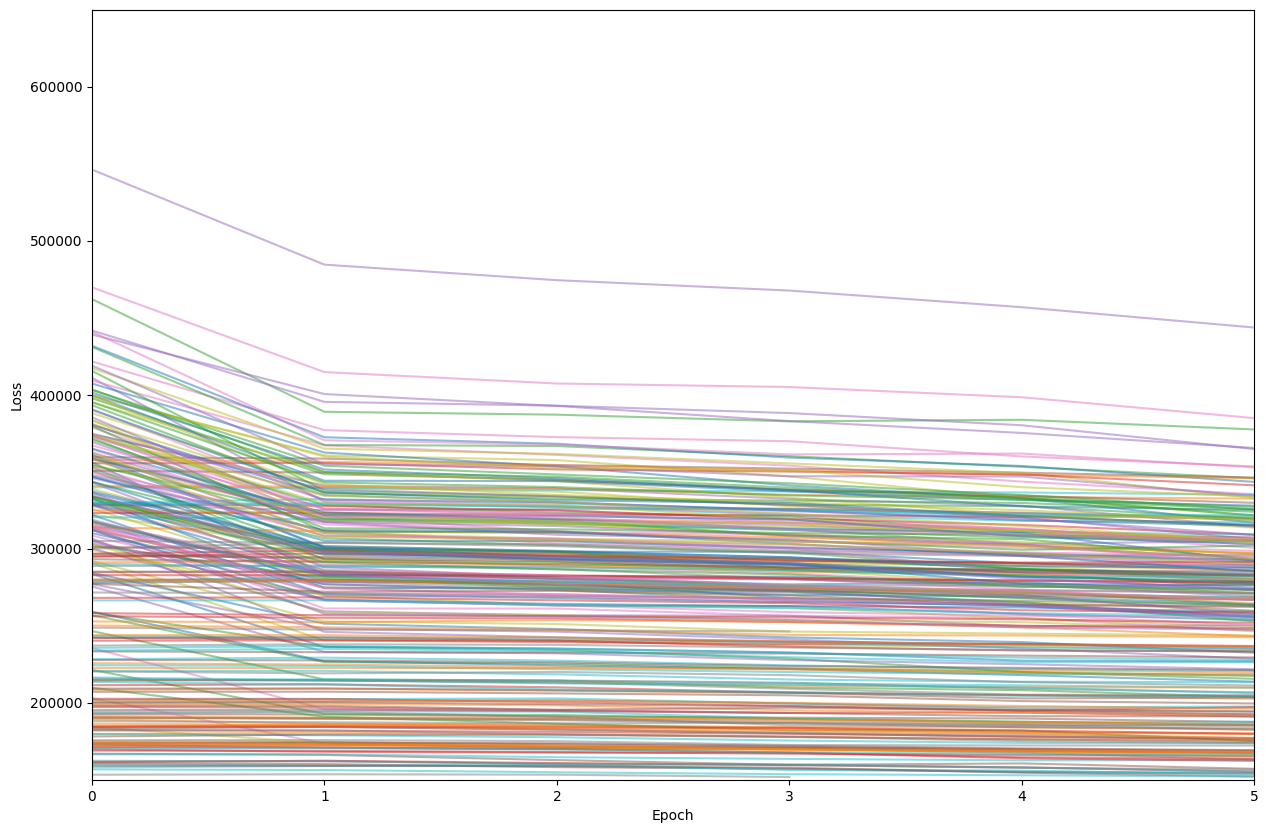

In [28]:
import matplotlib.pyplot as plt

def plot_losses(histories):
    plt.figure(figsize=(15, 10))  # increase y-axis size
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'Training Loss (Turbine {i+1})', alpha=0.5)
        plt.plot(history.history['val_loss'], label=f'Validation Loss (Turbine {i+1})', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.tick_params(axis='both')  # increase font size of tick labels
    plt.gca().set_ylim([150000,650000])  # set y-axis limits
    plt.gca().set_xlim([0,5])  # set y-axis limits
    plt.show()

# Plot the losses
plot_losses(turbine_histories)